
**Link:** https://www.kaggle.com/datasets/cpluzshrijayan/milkquality

**About dataset:**
This dataset is manually collected from observations. It helps us to build machine learning models to predict the quality of milk.
This dataset consists of 7 independent variables ie pH, Temperature, Taste, Odor, Fat, Turbidity, and Color.
Generally, the Grade or Quality of the milk depends on these parameters. These parameters play a vital role in the predictive analysis of the milk.

**Usage:**
The target variable is nothing but the Grade of the milk. It can be

Target

Low (Bad)

Medium (Moderate)

High (Good)

If Taste, Odor, Fat, and Turbidity are satisfied with optimal conditions then they will assign 1 otherwise 0.
Temperature and ph are given their actual values in the dataset.


**Column Details:**  
**pH**  
This Column defines PH alus of the milk which ranges from 3 to 9.5 max : 6.25 to 6.90  

**Temprature**  
This Column defines Temprature of the milk which ranges from 34'C to 90'C max : 34'C to 45.20'C  

**Taste**  
This Column defines Taste of the milk which is categorical data 0 (Bad) or 1 (Good) max : 1 (Good)  

**Odor**  
This Column defines Odor of the milk which is categorical data 0 (Bad) or 1 (Good) max : 0 (Bad)  

**Fat**  
This  Column defines Odor of the milk which is categorical data 0 (Low) or 1 (High) max : 1 (High)  

**Turbidity**  
This Column defines Turbidity of the milk which is categorical data 0 (Low) or 1 (High) max : 1 (High)  

**Colour**  
This Column defines Colour of the milk which ranges from 240 to 255 max : 255  

**Grade**  
This Column defines Grade (Target) of the milk which is categorical data Where Low (Bad) or Medium (Moderate) High (Good)

In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

no_seed = 572

import warnings
warnings.filterwarnings("ignore")

In [88]:
df_raw = pd.read_csv('data/milknew_raw.csv')
# df_raw = df_raw.reset_index()
print(df_raw.shape)
df_raw.head(3)

(1059, 8)


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low


# EDA

## general: info(), describe(), count()

In [89]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [90]:
df_raw.describe()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


In [91]:
df_raw.Grade.value_counts(dropna=False)

low       429
medium    374
high      256
Name: Grade, dtype: int64

## Correlation

In [92]:
df_raw.loc[df_raw['Grade']=='low', 'Grade'] = 0
df_raw.loc[df_raw['Grade']=='medium', 'Grade'] = 1
df_raw.loc[df_raw['Grade']=='high', 'Grade'] = 2
df_raw['Grade'] = df_raw['Grade'].astype(int)

In [93]:
def plot_correlation_heat(df_raw, method='pearson'):

    # Melt the DataFrame to long format for Altair
    corr_df = df_raw.corr(method)
    corr_mat = np.matrix(corr_df)
    # Plot the heatmap using Matplotlib
    plt.figure(figsize=(6, 4))
    heatmap = plt.imshow(corr_df, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(heatmap, label='Correlation')

    # Set axis labels
    plt.xticks(np.arange(len(corr_df.columns)), corr_df.columns, rotation=45)
    plt.yticks(np.arange(len(corr_df.columns)), corr_df.columns)

    # Display the correlation values in each cell
    for i in range(len(corr_df.columns)):
        for j in range(len(corr_df.columns)):
            plt.text(j, i, f'{corr_mat[i, j]:.2f}', ha='center', va='center', color='black' if abs(corr_mat[i, j]) < 0.5 else 'white')

    # Set plot title
    plt.title('Correlation Heatmap')

    # Show the plot
    plt.show()

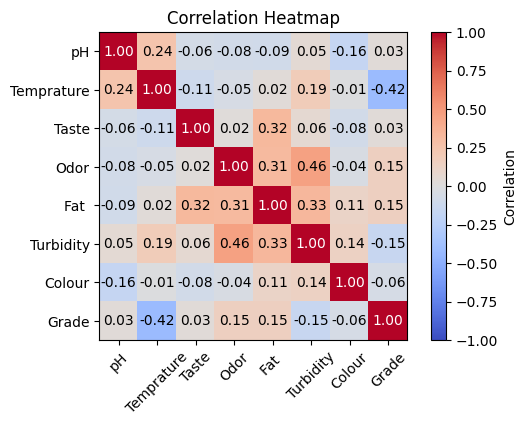

In [94]:
plot_correlation_heat(df_raw, method='pearson')


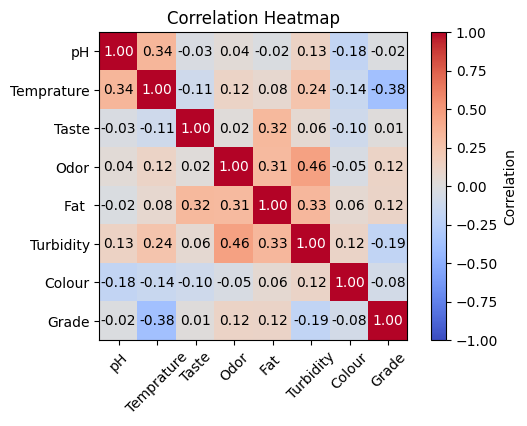

In [95]:
plot_correlation_heat(df_raw, method='spearman')